### General information

In this kernel I'll work with data from Histopathologic Cancer Detection Challenge. Our task is to identify metastatic cancer in small image patches taken from larger digital pathology scans. Or to be more precise - to classify 32x32 center crops as having cancer or not.

In [1]:
# libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import tqdm
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import cv2

In [2]:
!pip install albumentations > /dev/null 2>&1

In [3]:
!pip install pretrainedmodels > /dev/null 2>&1

In [4]:
import albumentations
from albumentations import torch as AT
import pretrainedmodels

### Preparing data

In [5]:
labels = pd.read_csv('../input/train_labels.csv')

In [6]:
print(f'{len(os.listdir("../input/train"))} pictures in train.')
print(f'{len(os.listdir("../input/test"))} pictures in test.')

220025 pictures in train.
57458 pictures in test.


Let's have a look at some images.

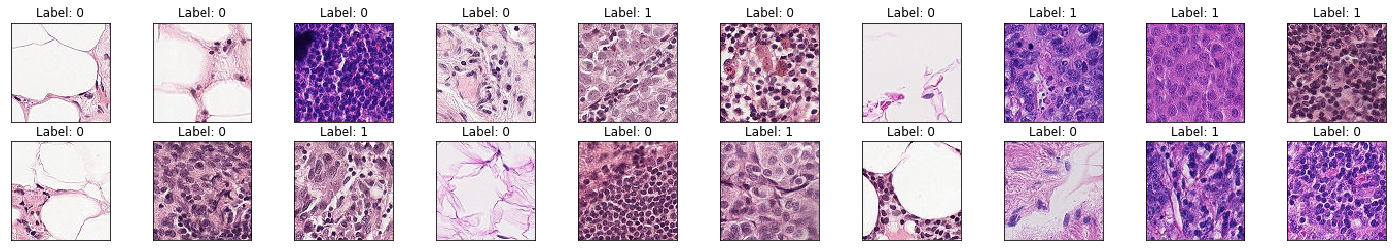

In [7]:
fig = plt.figure(figsize=(25, 4))
# display 20 images
train_imgs = os.listdir("../input/train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("../input/train/" + img)
    plt.imshow(im)
    lab = labels.loc[labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

Well, I can't find where the cancer is, though it seems cancer means some big cells. Let's hope that the model will be able to do it.

In [8]:
labels.label.value_counts()

0    130908
1     89117
Name: label, dtype: int64

No disbalance here. Let's start building a model.

### Model from scratch

At first I'll try to build a naive model from scratch. And I'll use 32x32 images, so that we cam directly classify the patches, which are interesting to us.

In [9]:
data_transforms = transforms.Compose([
    transforms.CenterCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
data_transforms_test = transforms.Compose([
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [10]:
# indices for validation
tr, val = train_test_split(labels.label, stratify=labels.label, test_size=0.1)

I haven't found a way to load data in Pytorch, when all train images are in one folder without subfolders. I have found an alternative - writing my own class for dataset creation.

In [11]:
# dictionary with labels and ids of train data
img_class_dict = {k:v for k, v in zip(labels.id, labels.label)}

In [12]:
class CancerDataset(Dataset):
    def __init__(self, datafolder, datatype='train', transform = transforms.Compose([transforms.CenterCrop(32),transforms.ToTensor()]), labels_dict={}):
        self.datafolder = datafolder
        self.datatype = datatype
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform
        self.labels_dict = labels_dict
        if self.datatype == 'train':
            self.labels = [labels_dict[i.split('.')[0]] for i in self.image_files_list]
        else:
            self.labels = [0 for _ in range(len(self.image_files_list))]

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder, self.image_files_list[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        img_name_short = self.image_files_list[idx].split('.')[0]

        if self.datatype == 'train':
            label = self.labels_dict[img_name_short]
        else:
            label = 0
        return image, label

In [13]:
%%time
# Load train data 
dataset = CancerDataset(datafolder='../input/train/', datatype='train', transform=data_transforms, labels_dict=img_class_dict)

CPU times: user 236 ms, sys: 128 ms, total: 364 ms
Wall time: 367 ms


In [14]:
# # get labels in correct order.
# ims = pd.DataFrame(dataset.image_files_list, columns=['img'])
# ims['img'] = ims['img'].apply(lambda x: x.split('.')[0])
# joined = ims.join(labels)
# lbs = joined.label.values
# dataset.labels = lbs

In [15]:
test_set = CancerDataset(datafolder='../input/test/', datatype='test', transform=data_transforms_test)

In [16]:
train_sampler = SubsetRandomSampler(list(tr.index))
valid_sampler = SubsetRandomSampler(list(val.index))
batch_size = 512
num_workers = 0
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)

#### Model

This is a simple CNN structure.

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)
        self.dropout = nn.Dropout(0.2)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        #x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.sig(self.fc3(x))
        return x

In [18]:
# model_conv = Net()

In [19]:
# model_conv.cuda()
criterion = nn.BCELoss()

# optimizer = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Training.

In [20]:
# valid_loss_min = np.Inf
# patience = 7
# # current number of epochs, where validation loss didn't increase
# p = 0
# # whether training should be stopped
# stop = False

# # number of epochs to train the model
# n_epochs = 10
# for epoch in range(1, n_epochs+1):
#     print(time.ctime(), 'Epoch:', epoch)

#     train_loss = []
#     exp_lr_scheduler.step()
#     train_auc = []

#     for batch_i, (data, target) in enumerate(train_loader):

#         data, target = data.cuda(), target.cuda()

#         optimizer.zero_grad()
#         output = model_conv(data)
#         loss = criterion(output[:,1], target.float())
#         train_loss.append(loss.item())
        
#         a = target.data.cpu().numpy()
#         b = output[:,-1].detach().cpu().numpy()
#         train_auc.append(roc_auc_score(a, b))

#         loss.backward()
#         optimizer.step()
    
#     model_conv.eval()
#     val_loss = []
#     val_auc = []
#     for batch_i, (data, target) in enumerate(valid_loader):
#         data, target = data.cuda(), target.cuda()
#         output = model_conv(data)

#         loss = criterion(output[:,1], target.float())

#         val_loss.append(loss.item()) 
#         a = target.data.cpu().numpy()
#         b = output[:,-1].detach().cpu().numpy()
#         val_auc.append(roc_auc_score(a, b))

#     print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}, train auc: {np.mean(train_auc):.4f}, valid acc: {np.mean(val_auc):.4f}')
    
#     valid_loss = np.mean(val_loss)
#     if valid_loss <= valid_loss_min:
#         print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
#         valid_loss_min,
#         valid_loss))
#         torch.save(model_conv.state_dict(), 'model.pt')
#         valid_loss_min = valid_loss
#         p = 0

#     # check if validation loss didn't improve
#     if valid_loss > valid_loss_min:
#         p += 1
#         print(f'{p} epochs of increasing val loss')
#         if p > patience:
#             print('Stopping training')
#             stop = True
#             break        
            
#     if stop:
#         break

### Using pretrained model.

And now let's try something better - pre-trained net. I'll be using Resnet. 

It is very important to remember, that Resnet requires images with 224x224 height and width. So I'll pad the imaged and create new loaders.

In [21]:
class CancerDataset(Dataset):
    def __init__(self, datafolder, datatype='train', transform = transforms.Compose([transforms.CenterCrop(32),transforms.ToTensor()]), labels_dict={}):
        self.datafolder = datafolder
        self.datatype = datatype
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform
        self.labels_dict = labels_dict
        if self.datatype == 'train':
            self.labels = [labels_dict[i.split('.')[0]] for i in self.image_files_list]
        else:
            self.labels = [0 for _ in range(len(self.image_files_list))]

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder, self.image_files_list[idx])
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = self.transform(image=img)
        image = image['image']

        img_name_short = self.image_files_list[idx].split('.')[0]

        if self.datatype == 'train':
            label = self.labels_dict[img_name_short]
        else:
            label = 0
        return image, label

In [22]:
data_transforms = albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.HorizontalFlip(),
    albumentations.RandomBrightness(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.JpegCompression(80),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    AT.ToTensor()
    ])
data_transforms_test = albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.Normalize(),
    AT.ToTensor()
    ])

dataset = CancerDataset(datafolder='../input/train/', datatype='train', transform=data_transforms, labels_dict=img_class_dict)
test_set = CancerDataset(datafolder='../input/test/', datatype='test', transform=data_transforms_test)
train_sampler = SubsetRandomSampler(list(tr.index))
valid_sampler = SubsetRandomSampler(list(val.index))
batch_size = 32
num_workers = 0
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)

In [23]:
model_conv = torchvision.models.resnet50(pretrained=True)
for i, param in model_conv.named_parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 98205237.19it/s]


In [24]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(2048, 2)

#### Training

In [25]:
model_conv.cuda()
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.005, momentum=0.99)
#scheduler = CyclicLR(optimizer, base_lr=lr, max_lr=0.01, step_size=5, mode='triangular2')
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [26]:
valid_loss_min = np.Inf
patience = 5
# current number of epochs, where validation loss didn't increase
p = 0
# whether training should be stopped
stop = False

# number of epochs to train the model
n_epochs = 7
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)

    train_loss = []
    # scheduler.step(epoch)
    train_auc = []

    for batch_i, (data, target) in enumerate(train_loader):

        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model_conv(data)
        loss = criterion(output[:,1], target.float())
        train_loss.append(loss.item())
        
        a = target.data.cpu().numpy()
        b = output[:,-1].detach().cpu().numpy()
        # train_auc.append(roc_auc_score(a, b))

        loss.backward()
        optimizer.step()
    
    model_conv.eval()
    val_loss = []
    val_auc = []
    for batch_i, (data, target) in enumerate(valid_loader):
        data, target = data.cuda(), target.cuda()
        output = model_conv(data)

        loss = criterion(output[:,1], target.float())

        val_loss.append(loss.item()) 
        a = target.data.cpu().numpy()
        b = output[:,-1].detach().cpu().numpy()
        # val_auc.append(roc_auc_score(a, b))

    # print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}, train auc: {np.mean(train_auc):.4f}, valid auc: {np.mean(val_auc):.4f}')
    print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}.')
    
    valid_loss = np.mean(val_loss)
    scheduler.step(valid_loss)
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model_conv.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
        p = 0

    # check if validation loss didn't improve
    if valid_loss > valid_loss_min:
        p += 1
        print(f'{p} epochs of increasing val loss')
        if p > patience:
            print('Stopping training')
            stop = True
            break        
            
    if stop:
        break

Sun Mar 24 17:34:13 2019 Epoch: 1
Epoch 1, train loss: 1.0078, valid loss: 1.7704.
Validation loss decreased (inf --> 1.770353).  Saving model ...
Sun Mar 24 17:59:34 2019 Epoch: 2
Epoch 2, train loss: 0.8223, valid loss: 0.8210.
Validation loss decreased (1.770353 --> 0.821039).  Saving model ...
Sun Mar 24 18:21:59 2019 Epoch: 3
Epoch 3, train loss: 0.8425, valid loss: 0.9579.
1 epochs of increasing val loss
Sun Mar 24 18:44:25 2019 Epoch: 4
Epoch 4, train loss: 0.7698, valid loss: 0.5397.
Validation loss decreased (0.821039 --> 0.539672).  Saving model ...
Sun Mar 24 19:06:53 2019 Epoch: 5
Epoch 5, train loss: 0.7329, valid loss: 0.5634.
1 epochs of increasing val loss
Sun Mar 24 19:29:11 2019 Epoch: 6
Epoch 6, train loss: 0.7889, valid loss: 0.8991.
2 epochs of increasing val loss
Sun Mar 24 19:51:28 2019 Epoch: 7
Epoch 7, train loss: 0.8509, valid loss: 1.2853.
3 epochs of increasing val loss


In [27]:
model_conv.eval()
preds = []
for batch_i, (data, target) in enumerate(test_loader):
    data, target = data.cuda(), target.cuda()
    output = model_conv(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)

In [28]:
test_preds = pd.DataFrame({'imgs': test_set.image_files_list, 'preds': preds})

In [29]:
test_preds['imgs'] = test_preds['imgs'].apply(lambda x: x.split('.')[0])

In [30]:
sub = pd.read_csv('../input/sample_submission.csv')

In [31]:
sub = pd.merge(sub, test_preds, left_on='id', right_on='imgs')
sub = sub[['id', 'preds']]
sub.columns = ['id', 'label']
sub.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,3.446846
1,95596b92e5066c5c52466c90b69ff089b39f2737,8.531521
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,-9.365259
3,2c35657e312966e9294eac6841726ff3a748febf,-6.302567
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,-2.825668


In [32]:
sub.to_csv('sub.csv', index=False)